In [101]:
import numpy as np
import pandas as pd
import math
import datetime
from sklearn.utils import shuffle

### Defining custom functions

In [102]:
def load_dataset(path):
    df = pd.read_csv(path, sep=',')
    df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").date().strftime("%B %d, %Y"))
    return df

In [103]:
def add_previous_npis(npis_prev, npis_curr):
    for prev, curr in zip(npis_prev, npis_curr):
        df[prev] = df.groupby('CountryName')[curr].shift()

    df.dropna(subset=npis_prev, inplace=True)

In [104]:
def prepare_samples_and_labels():
    #prepare samples
    samples = df[npis_prev]
    samples.insert(0, 'StringencyIndex_Average', df['StringencyIndex_Average'].div(100))
    samples = samples.to_numpy()

    #prepare labels
    labels = []
    for npi in npis:
        labels.append(df[npi].to_numpy())

    return samples, labels

In [105]:
def split_to_train_and_test(samples, labels, ratio=0.85):
    split_index = math.floor(ratio * len(samples))

    train_samples = samples[:split_index]
    train_labels = []

    for label in labels:
        train_labels.append(label[:split_index])

    test_samples = samples[split_index:]
    test_labels = []

    for label in labels:
        test_labels.append(label[split_index:])

    return train_samples, train_labels, test_samples, test_labels

### Preprocess data

In [106]:
npis = [
    "C1M",
    "C2M",
    "C3M",
    "C4M",
    "C5M",
    "C6M",
    "C7M",
    "C8M",
    "H1"
]

npis_prev = [
    "C1M_prev",
    "C2M_prev",
    "C3M_prev",
    "C4M_prev",
    "C5M_prev",
    "C6M_prev",
    "C7M_prev",
    "C8M_prev",
    "H1_prev"
]

npi_labels = [
    "School closing",
    "Workplace closing",
    "Cancel public events",
    "Restrictions on gatherings",
    "Close public transport",
    "Stay at home requirements",
    "Restrictions on internal movement",
    "International travel controls",
    "Public information campaigns"
]

In [107]:
df = load_dataset("./OxCGRT_clean.csv")

In [108]:
df.head(10)

,Continent,CountryName,Date,C1M,C1M_Flag,C2M,C2M_Flag,C3M,C3M_Flag,C4M,...,C8M,H1,H1_Flag,ConfirmedCases,ConfirmedDeaths,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,Prev_StringencyIndex_Average,Daily_StringencyIndex_Change
0,NaN,Aruba,"March 16, 2020",3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,NV,0.0,11.11,0.00,0.000000
1,NaN,Aruba,"March 17, 2020",3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,3.0,0.0,NV,0.0,22.22,11.11,0.111111
2,NaN,Aruba,"March 18, 2020",3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,1.0,4.0,0.0,NV,0.0,33.33,22.22,0.111111
3,NaN,Aruba,"March 21, 2020",3.0,1.0,2.0,1.0,0.0,0.0,0.0,...,4.0,2.0,1.0,5.0,0.0,NV,0.0,44.44,33.33,0.111111
4,NaN,Aruba,"March 29, 2020",3.0,1.0,3.0,1.0,2.0,1.0,4.0,...,4.0,2.0,1.0,50.0,0.0,NV,0.0,85.19,44.44,0.518519
5,NaN,Aruba,"April 10, 2020",3.0,1.0,3.0,1.0,2.0,1.0,4.0,...,4.0,2.0,1.0,86.0,0.0,NV,0.0,88.89,85.19,0.111111
6,NaN,Aruba,"May 04, 2020",3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,4.0,2.0,1.0,100.0,2.0,NV,0.0,81.48,88.89,0.148148
7,NaN,Aruba,"May 18, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,4.0,2.0,1.0,101.0,3.0,NV,0.0,66.67,81.48,0.074074
8,NaN,Aruba,"May 28, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,4.0,2.0,1.0,101.0,3.0,NV,0.0,62.96,66.67,0.037037
9,NaN,Aruba,"May 31, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,4.0,2.0,1.0,101.0,3.0,NV,0.0,57.41,62.96,0.055556


In [109]:
add_previous_npis(npis_prev, npis)

In [110]:
samples, labels = prepare_samples_and_labels()

In [111]:
samples

array([[0.2222, 3.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.3333, 3.    , 0.    , ..., 0.    , 4.    , 0.    ],
       [0.4444, 3.    , 0.    , ..., 0.    , 4.    , 2.    ],
       ...,
       [0.5263, 1.    , 1.    , ..., 1.    , 1.    , 2.    ],
       [0.5262, 1.    , 1.    , ..., 1.    , 1.    , 2.    ],
       [0.537 , 1.    , 1.    , ..., 1.    , 1.    , 2.    ]])

In [112]:
labels

[array([3., 3., 3., ..., 1., 1., 1.]),
 array([0., 0., 2., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 3., 3., 3.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([0., 0., 1., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([4., 4., 4., ..., 1., 1., 1.]),
 array([0., 2., 2., ..., 2., 2., 2.])]

In [113]:
not_shuffled_samples = samples[15000:16000]
not_shuffled_labels = []
for label in labels:
    not_shuffled_labels.append(label[15000:16000])


In [114]:
samples, *labels = shuffle(samples, *labels, random_state=0)

In [115]:
train_samples, train_labels, test_samples, test_labels = split_to_train_and_test(samples, labels)

In [116]:
train_samples

array([[0.6593, 3.    , 3.    , ..., 2.    , 3.    , 2.    ],
       [0.6111, 3.    , 2.    , ..., 0.    , 3.    , 2.    ],
       [0.4658, 0.    , 2.    , ..., 0.    , 1.    , 2.    ],
       ...,
       [0.7685, 3.    , 3.    , ..., 0.    , 3.    , 2.    ],
       [0.1959, 0.    , 2.    , ..., 0.    , 1.    , 2.    ],
       [0.4578, 2.    , 1.    , ..., 0.    , 3.    , 2.    ]])

In [117]:
train_labels

[array([3., 3., 0., ..., 3., 0., 2.]),
 array([3., 1., 2., ..., 3., 2., 1.]),
 array([2., 2., 1., ..., 2., 0., 1.]),
 array([0., 3., 2., ..., 4., 0., 0.]),
 array([2., 0., 2., ..., 1., 0., 1.]),
 array([2., 2., 1., ..., 2., 0., 0.]),
 array([2., 0., 0., ..., 0., 0., 0.]),
 array([3., 3., 1., ..., 3., 1., 3.]),
 array([2., 2., 2., ..., 2., 2., 2.])]

## MTL model

In [118]:
from keras.optimizers import Adam
from keras import Input, Model
from keras.layers import Dense

num_tasks = 9
num_features = num_tasks + 1

shared_layer_1 = Dense(32, input_dim=num_features, activation='relu')
shared_layer_2 = Dense(32, activation='relu')

task_1_output_layer = Dense(5, activation='softmax', name='C1')
task_2_output_layer = Dense(5, activation='softmax', name='C2')
task_3_output_layer = Dense(5, activation='softmax', name='C3')
task_4_output_layer = Dense(5, activation='softmax', name='C4')
task_5_output_layer = Dense(5, activation='softmax', name='C5')
task_6_output_layer = Dense(5, activation='softmax', name='C6')
task_7_output_layer = Dense(5, activation='softmax', name='C7')
task_8_output_layer = Dense(5, activation='softmax', name='C8')
task_9_output_layer = Dense(5, activation='softmax', name='H1')

input_tensor = Input(shape=(num_features,))

shared_tensor = shared_layer_1(input_tensor)
shared_tensor = shared_layer_2(shared_tensor)

task_1_output = task_1_output_layer(shared_tensor)
task_2_output = task_2_output_layer(shared_tensor)
task_3_output = task_3_output_layer(shared_tensor)
task_4_output = task_4_output_layer(shared_tensor)
task_5_output = task_5_output_layer(shared_tensor)
task_6_output = task_6_output_layer(shared_tensor)
task_7_output = task_7_output_layer(shared_tensor)
task_8_output = task_8_output_layer(shared_tensor)
task_9_output = task_9_output_layer(shared_tensor)

mtl_model = Model(inputs=input_tensor, outputs=[
    task_1_output,
    task_2_output,
    task_3_output,
    task_4_output,
    task_5_output,
    task_6_output,
    task_7_output,
    task_8_output,
    task_9_output], )

mtl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'C1': 'sparse_categorical_crossentropy',
        'C2': 'sparse_categorical_crossentropy',
        'C3': 'sparse_categorical_crossentropy',
        'C4': 'sparse_categorical_crossentropy',
        'C5': 'sparse_categorical_crossentropy',
        'C6': 'sparse_categorical_crossentropy',
        'C7': 'sparse_categorical_crossentropy',
        'C8': 'sparse_categorical_crossentropy',
        'H1': 'sparse_categorical_crossentropy'
    },
    metrics={
        'C1': 'accuracy',
        'C2': 'accuracy',
        'C3': 'accuracy',
        'C4': 'accuracy',
        'C5': 'accuracy',
        'C6': 'accuracy',
        'C7': 'accuracy',
        'C8': 'accuracy',
        'H1': 'accuracy'
    }
)
mtl_model.summary()

mtl_model.fit(
    x=train_samples.reshape(-1, num_features),
    y=train_labels,
    validation_split=0.1,
    batch_size=10,
    epochs=1000,
    shuffle=True,
    verbose=2
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 32)           352         ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 32)           1056        ['dense_4[0][0]']                
                                                                                                  
 C1 (Dense)                     (None, 5)            165         ['dense_5[0][0]']                
                                                                                            

# Predict

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## test data

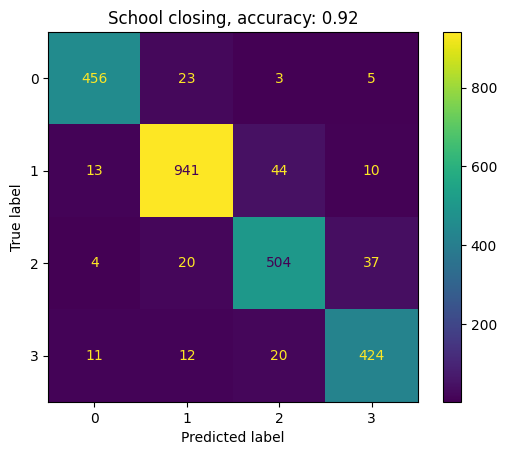

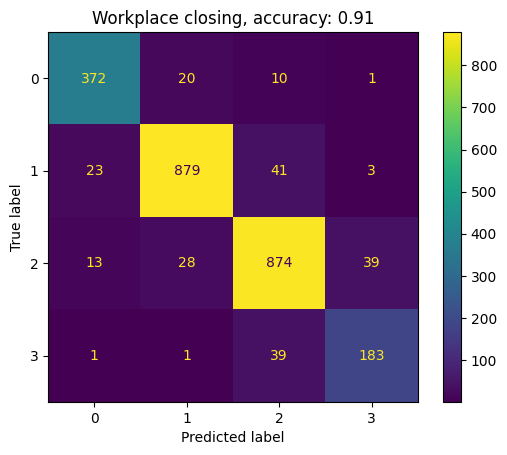

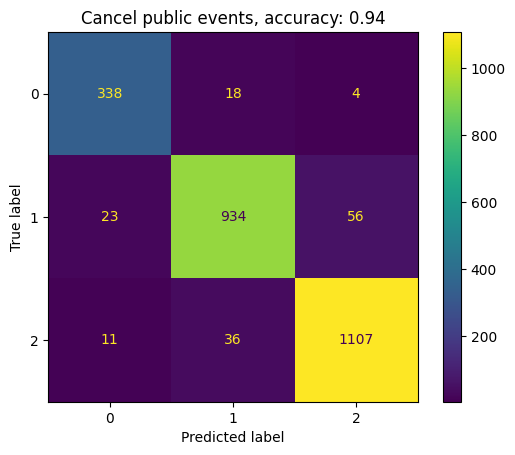

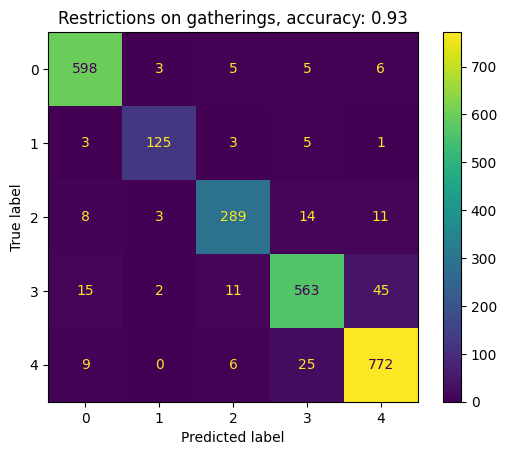

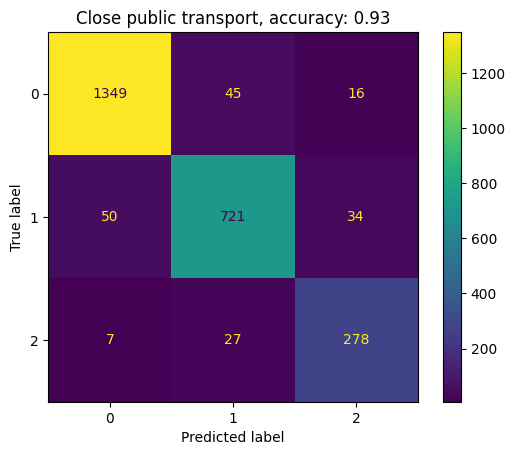

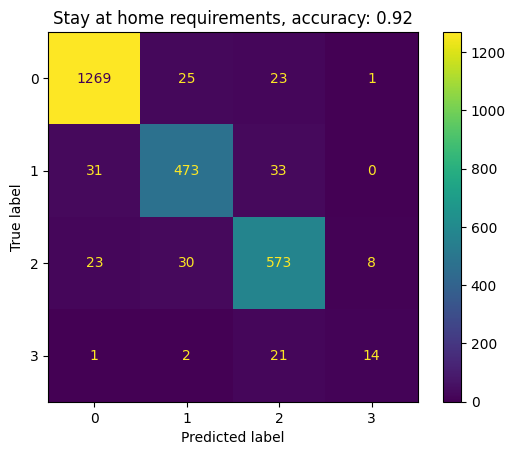

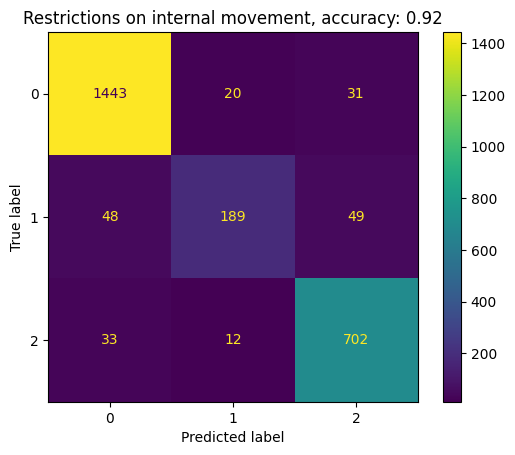

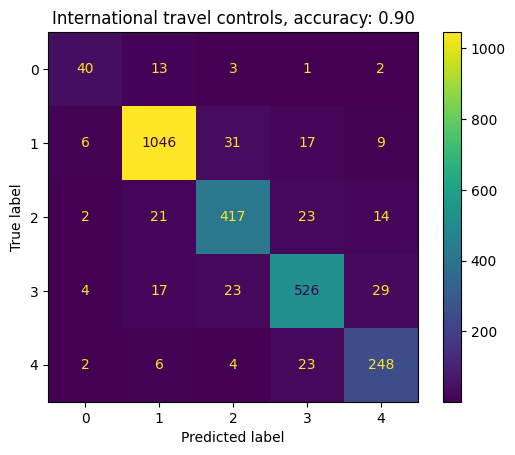

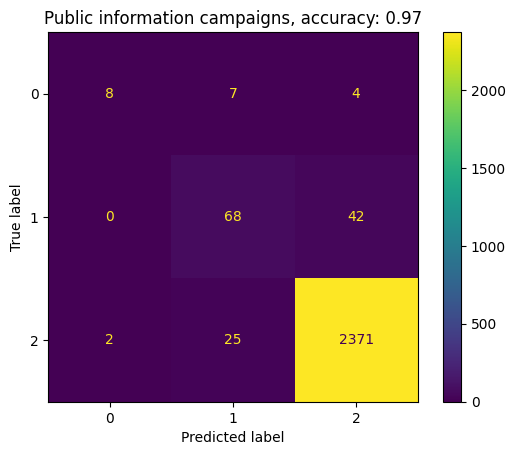

In [120]:
from sklearn.metrics import accuracy_score

predictions = mtl_model.predict(
    x=test_samples.reshape(-1, num_features),
    batch_size=10,
    verbose=0)

predictions = np.array(predictions)

f = lambda x: np.argmax(x, axis=-1)
predictions = f(predictions)

for idx, pred in enumerate(predictions):
    cm = confusion_matrix(y_true=test_labels[idx], y_pred=pred)
    accuracy = accuracy_score(test_labels[idx], pred).round(2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title(npi_labels[idx] + ", accuracy: %.2f" % accuracy)
    plt.show()

## Recursive predictions

In [121]:
iterative_predictions = []
next_samples = []

predicted_sample = not_shuffled_samples[99]

for i in range(100, 200):
    predictions = mtl_model.predict(
        x=predicted_sample.reshape(-1, num_features),
        batch_size=10,
        verbose=0)

    predictions = np.array(predictions)

    f = lambda x: np.argmax(x, axis=-1)
    predictions = f(predictions)
    predicted_sample = np.concatenate(([not_shuffled_samples[i][0]], predictions.flatten()))
    next_samples.append(predicted_sample)
    iterative_predictions.append(predictions.flatten())

print(type(np.array(iterative_predictions)))
print(type(not_shuffled_samples))

zipped_predicted_npis = list(zip(*iterative_predictions))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Barcharts

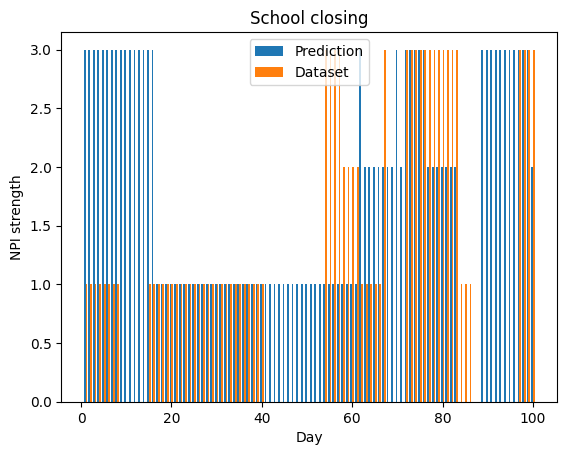

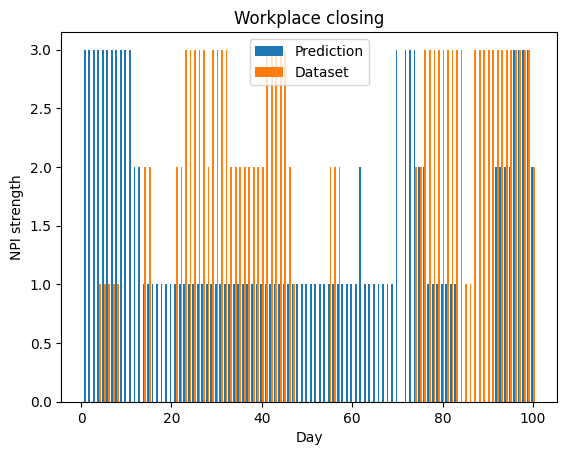

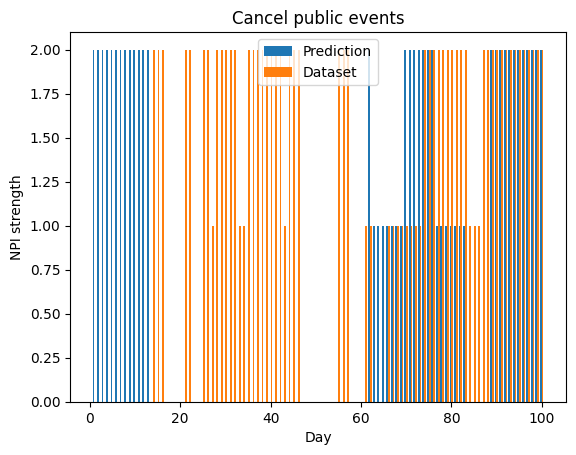

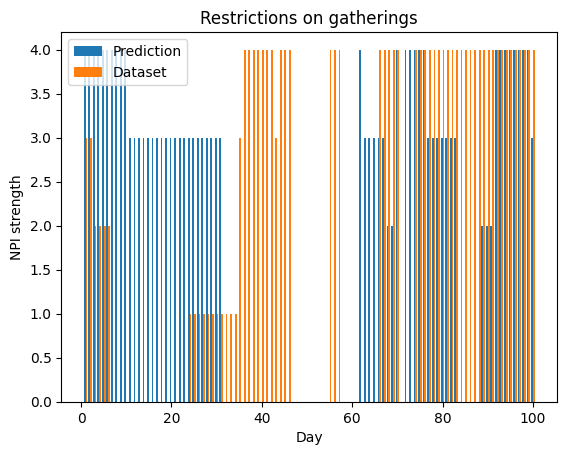

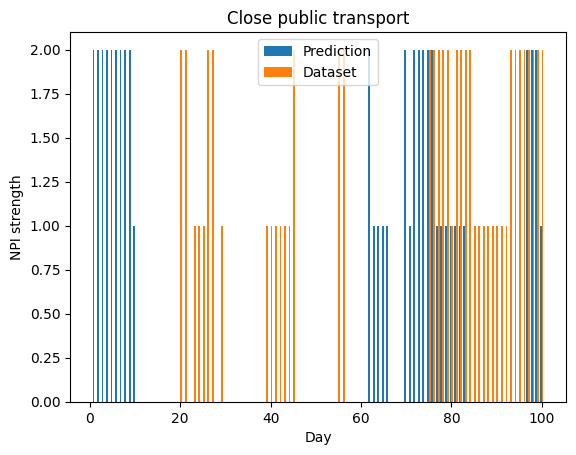

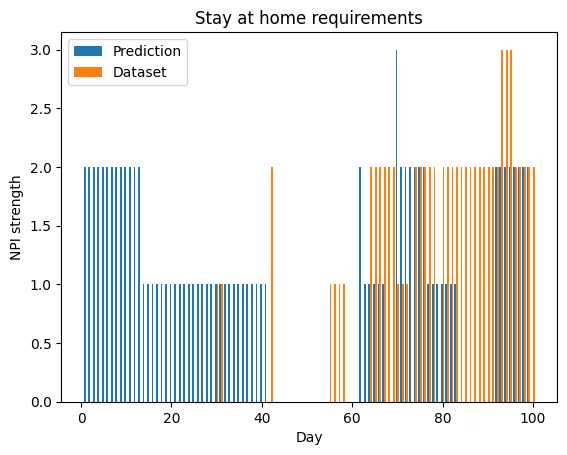

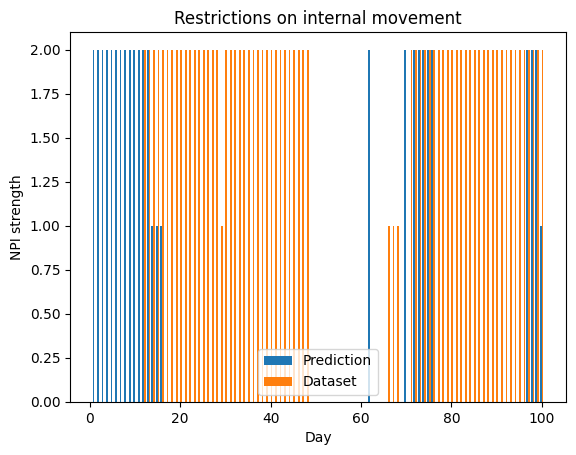

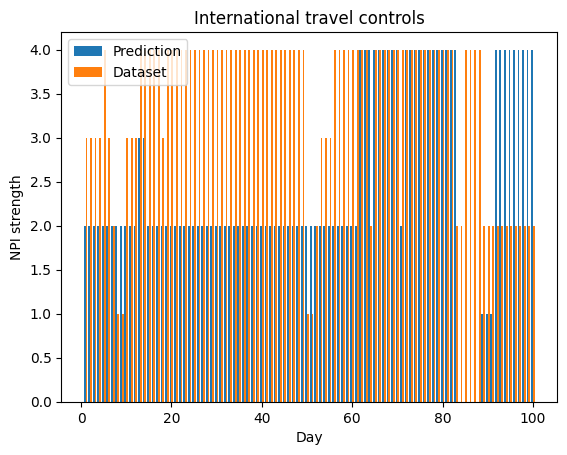

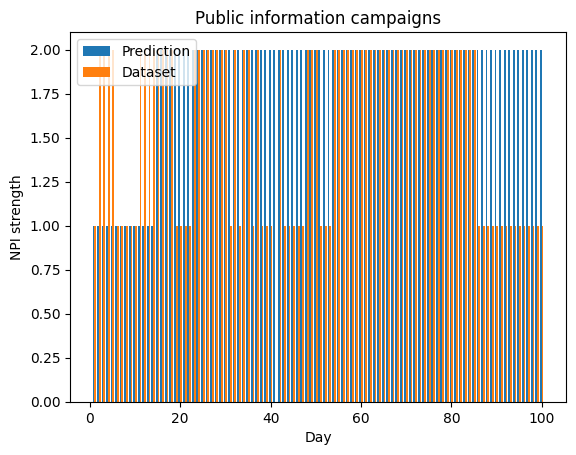

In [122]:
# Define the arrays
x = np.arange(1, 101)

for i in range(0, 9):
    predicted_y = np.array(zipped_predicted_npis[i][0:100])
    label_y = not_shuffled_labels[i][0:100]

    # Create the bar chart
    fig, ax = plt.subplots()
    ax.bar(x - 0.2, predicted_y, width=0.4, label='Prediction')
    ax.bar(x + 0.2, label_y, width=0.4, label='Dataset')

    # Add labels and legend
    ax.set_xlabel('Day')
    ax.set_ylabel('NPI strength')
    ax.set_title(npi_labels[i])
    ax.legend()

    # Display the chart
    plt.show()

In [123]:
df.head(10)

,Continent,CountryName,Date,C1M,C1M_Flag,C2M,C2M_Flag,C3M,C3M_Flag,C4M,...,Daily_StringencyIndex_Change,C1M_prev,C2M_prev,C3M_prev,C4M_prev,C5M_prev,C6M_prev,C7M_prev,C8M_prev,H1_prev
1,NaN,Aruba,"March 17, 2020",3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.111111,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,Aruba,"March 18, 2020",3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.111111,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,NaN,Aruba,"March 21, 2020",3.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.111111,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
4,NaN,Aruba,"March 29, 2020",3.0,1.0,3.0,1.0,2.0,1.0,4.0,...,0.518519,3.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0
5,NaN,Aruba,"April 10, 2020",3.0,1.0,3.0,1.0,2.0,1.0,4.0,...,0.111111,3.0,3.0,2.0,4.0,0.0,2.0,2.0,4.0,2.0
6,NaN,Aruba,"May 04, 2020",3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,0.148148,3.0,3.0,2.0,4.0,0.0,3.0,2.0,4.0,2.0
7,NaN,Aruba,"May 18, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.074074,3.0,2.0,2.0,4.0,0.0,2.0,2.0,4.0,2.0
8,NaN,Aruba,"May 28, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.037037,2.0,2.0,2.0,0.0,0.0,2.0,2.0,4.0,2.0
9,NaN,Aruba,"May 31, 2020",2.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.055556,2.0,2.0,2.0,0.0,0.0,1.0,2.0,4.0,2.0
10,NaN,Aruba,"June 08, 2020",1.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.037037,2.0,2.0,2.0,0.0,0.0,1.0,1.0,4.0,2.0


In [124]:
df = df[df['CountryName'] == "Poland"]
df.head(10)

,Continent,CountryName,Date,C1M,C1M_Flag,C2M,C2M_Flag,C3M,C3M_Flag,C4M,...,Daily_StringencyIndex_Change,C1M_prev,C2M_prev,C3M_prev,C4M_prev,C5M_prev,C6M_prev,C7M_prev,C8M_prev,H1_prev
12687,Europe,Poland,"February 27, 2020",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12688,Europe,Poland,"March 09, 2020",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
12689,Europe,Poland,"March 10, 2020",0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
12690,Europe,Poland,"March 12, 2020",3.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.166667,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0
12691,Europe,Poland,"March 14, 2020",3.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.074074,3.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0
12692,Europe,Poland,"March 15, 2020",3.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.111111,3.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0
12693,Europe,Poland,"March 31, 2020",3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,0.296296,3.0,2.0,2.0,0.0,0.0,0.0,1.0,4.0,2.0
12694,Europe,Poland,"April 09, 2020",3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,0.055556,3.0,2.0,2.0,4.0,0.0,2.0,2.0,4.0,2.0
12695,Europe,Poland,"April 20, 2020",3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,0.037037,3.0,2.0,2.0,4.0,1.0,2.0,2.0,4.0,2.0
12696,Europe,Poland,"May 25, 2020",2.0,1.0,2.0,1.0,2.0,1.0,4.0,...,0.074074,3.0,2.0,2.0,4.0,1.0,1.0,2.0,4.0,2.0


In [125]:
def step_plot(xlabel, ylabel, xvalue, yvalue, title, spacing, plot_si = True):
    fig, ax = plt.subplots()
    ax.step(xvalue, yvalue, label="NPI")
    if plot_si:
        ax.step(xvalue, indexes * max(yvalue), label=f"SI * {max(yvalue)}")
    ax.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)  # Adjust the rotation angle as needed
    plt.xticks(range(0, len(xvalue), spacing))  # Display every second label
    # plt.tight_layout()  # Optional: adjust layout to prevent label overlapping
    plt.show()

# plt.plot(indexes)
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Graph')
# plt.show()

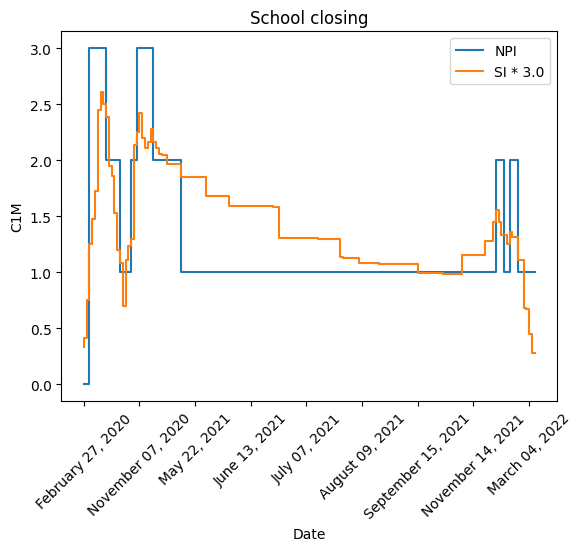

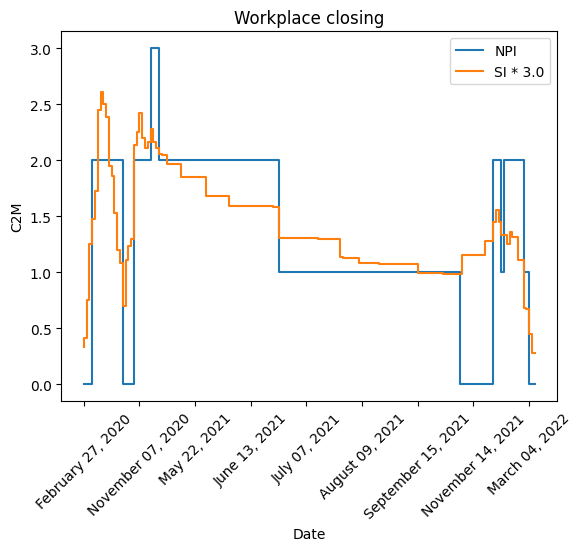

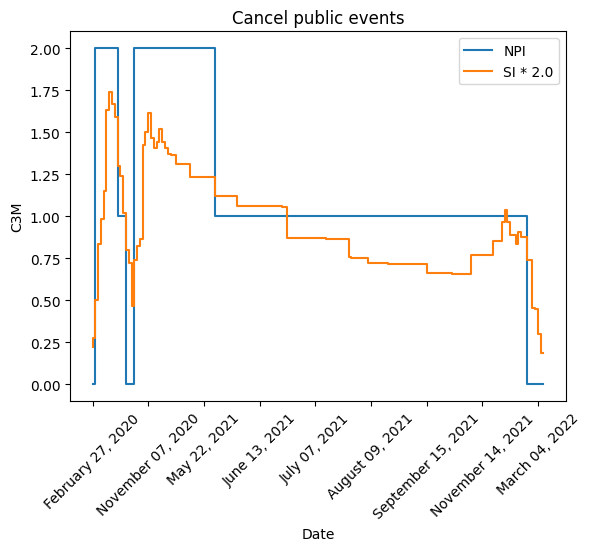

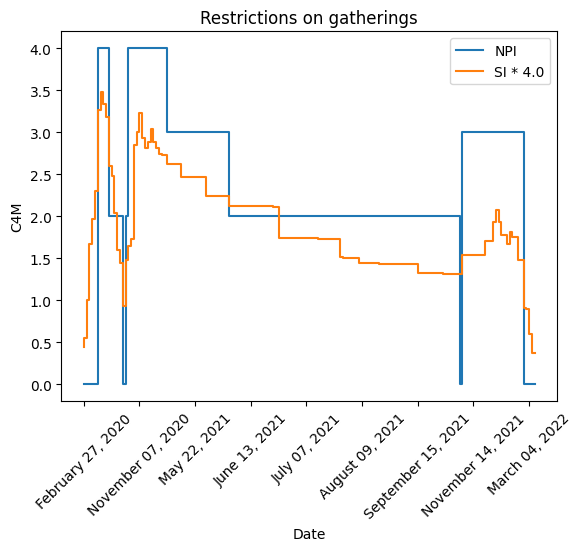

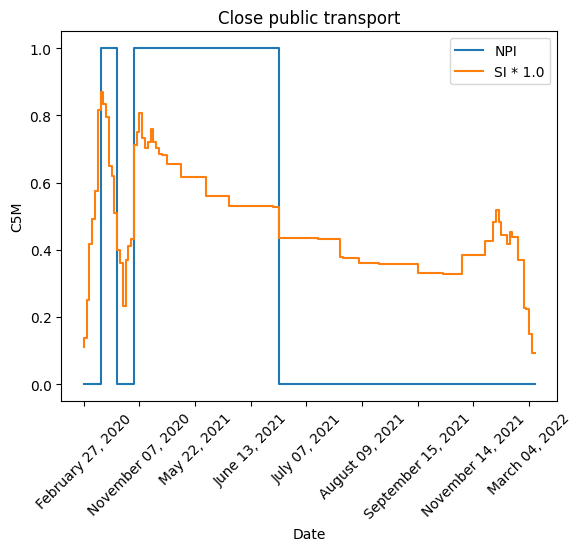

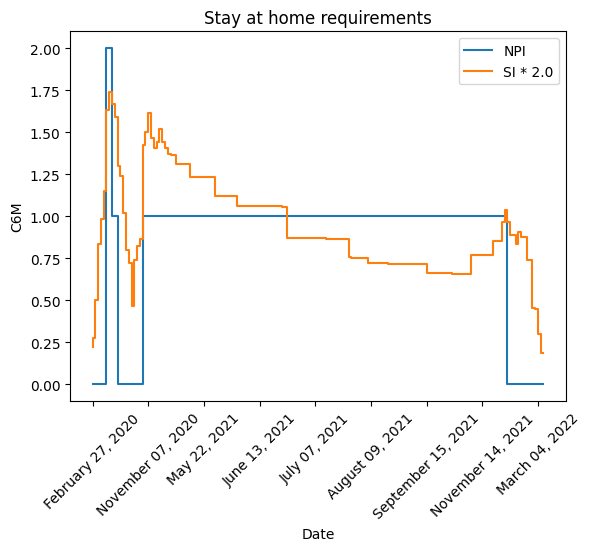

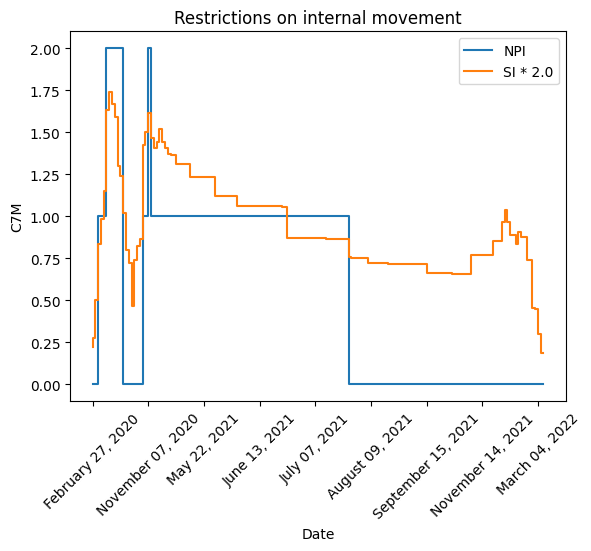

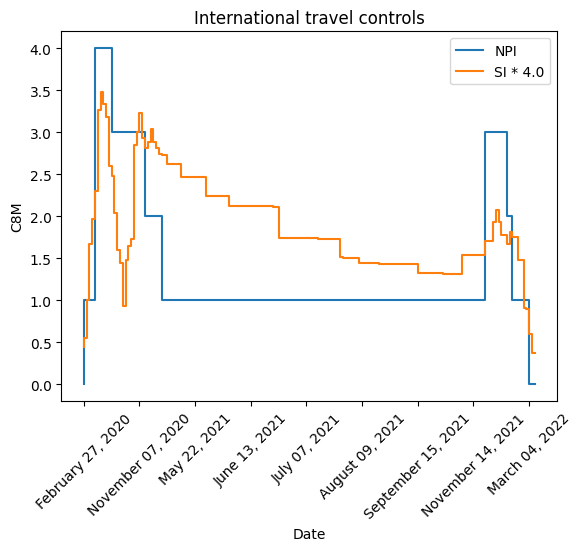

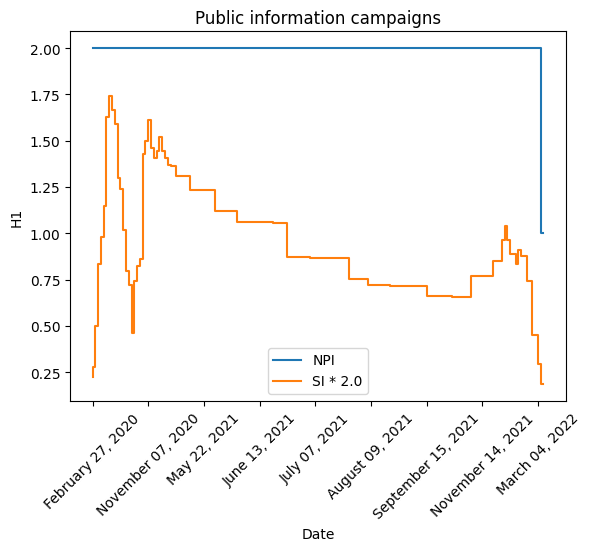

In [126]:
for i in range(0, 9):
    step_plot(xlabel='Date', ylabel=npis[i], xvalue=df['Date'], yvalue=df[npis[i]], title=npi_labels[i], spacing=20, plot_si=True)

In [159]:
def iterative_predict(init, indexes):
    f = lambda x: np.argmax(x, axis=-1)
    iterative_predictions = []

    for j in range(0, len(indexes)):
        predictions = mtl_model.predict(
            x=init.reshape(-1, num_features),
            batch_size=10,
            verbose=0)
        predictions = np.array(predictions)
        predictions = f(predictions)
        # print(indexes[j])
        # print(predictions.flatten())
        init = np.concatenate(([indexes[j]], predictions.flatten()))
        iterative_predictions.append(predictions.flatten())

    return list(zip(*iterative_predictions))

In [160]:
init = np.array([0111., 0, 0, 0, 0, 0, 0, 0, 0, 2])

indexes = df['StringencyIndex_Average'].tolist()
indexes = np.divide(indexes, 100)
indexes_no_first = indexes[1:]
print(len(indexes_no_first))

long_term_predictions = iterative_predict(init=init, indexes=indexes_no_first)

162


In [148]:
def plot_long_term_npis(predicted_npis):
    for i in range(0, 9):
        predicted_y = np.array(predicted_npis[i][0:])
        label_y = not_shuffled_labels[i][0:]

        # Create the bar chart
        fig, ax = plt.subplots()
        ax.bar(x - 0.2, predicted_y, width=0.4, label='Prediction')
        ax.bar(x + 0.2, label_y, width=0.4, label='Dataset')

        # Add labels and legend
        ax.set_xlabel('Day')
        ax.set_ylabel('NPI strength')
        ax.set_title(npi_labels[i])
        ax.legend()

        # Display the chart
        plt.show()

162


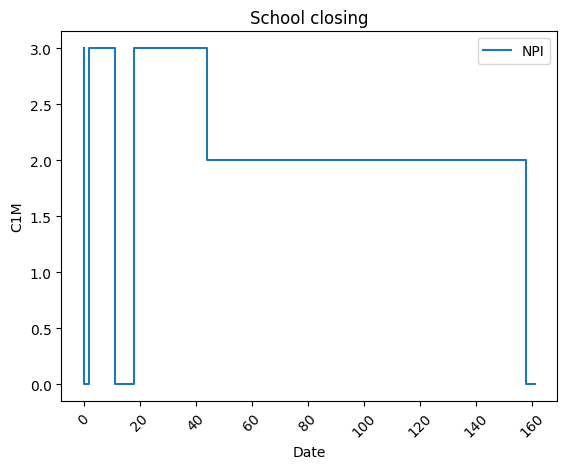

162


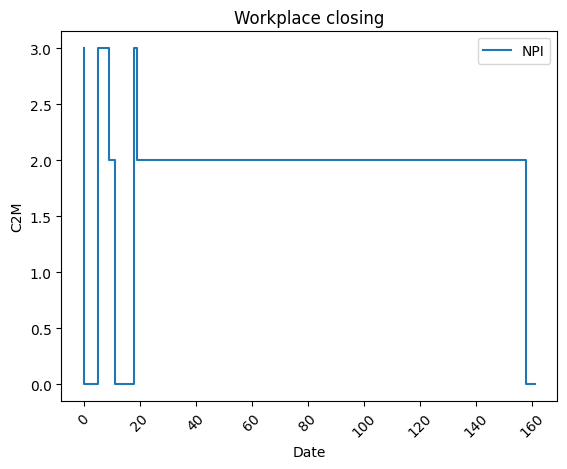

162


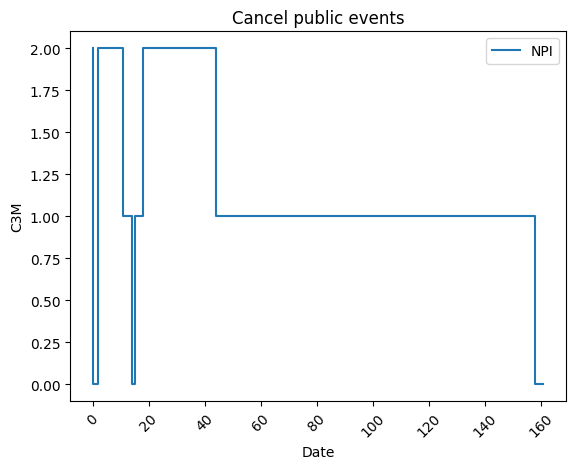

162


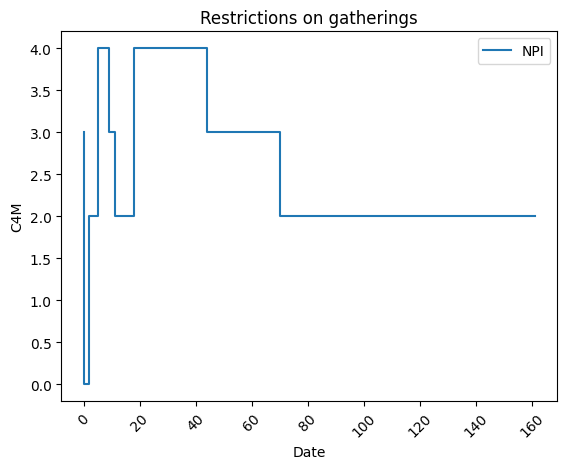

162


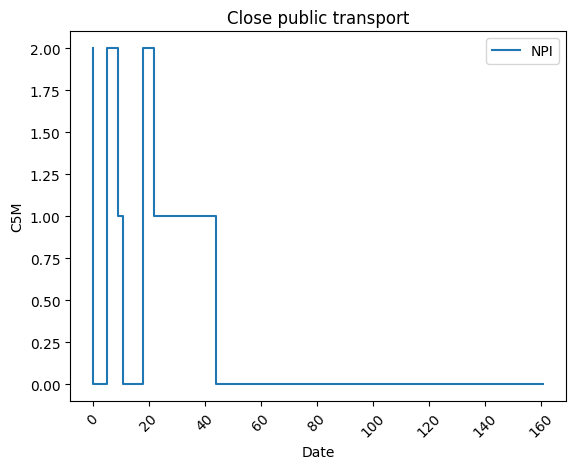

162


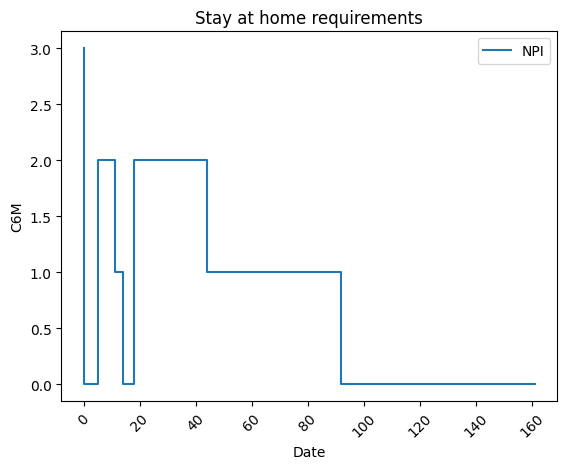

162


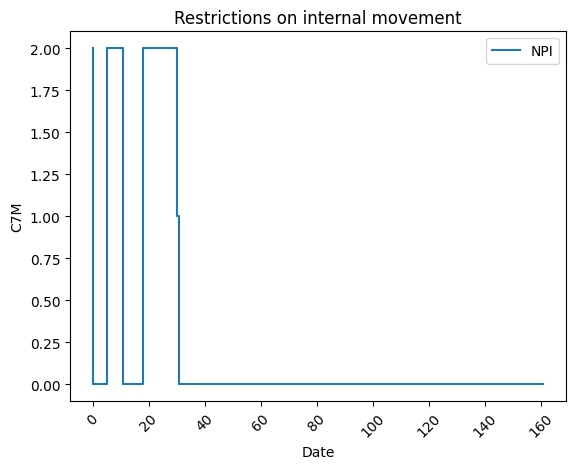

162


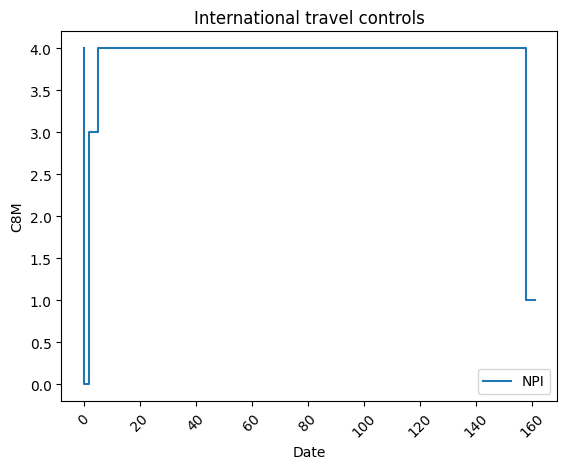

162


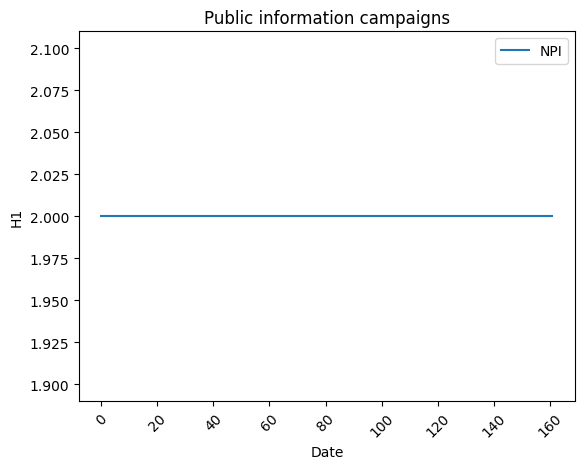

In [163]:
for i in range(0, 9):
    print(len(long_term_predictions[0]))
    step_plot(xlabel='Date', ylabel=npis[i], xvalue=range(len(long_term_predictions[i])),
              yvalue=long_term_predictions[i], title=npi_labels[i], spacing=20, plot_si=False)